In [606]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import networkx as nx
import matplotlib.pyplot as plt
import copy
import elitism

In [607]:
stations = ['A', 'B', 'C', 'D', 'E', 'S1', 'S2']
transitions = {
    'S1': ['A', 'B', 'C'],
    'S2': ['A', 'B', 'C', 'D'],
    'E': ['D']
}

graph_matrix = ((0, 0, 0, 0, 0, 1, 1),
                (0, 0, 0, 0, 0, 1, 1),
                (0, 0, 0, 0, 0, 1, 1),
                (0, 0, 0, 0, 1, 0, 1),
                (0, 0, 0, 1, 0, 0, 0),
                (1, 1, 1, 0, 0, 0, 0),
                (1, 1, 1, 1, 0, 0, 0))

In [608]:
mul_list = [
    {
        'st': 'A'
    },
    {
        'st': 'B'
    },
    {
        'st': 'B'
    },
]

In [609]:
lacomotive_type = ['S1', 'S2']

vagon_list = [
    {
        'st': 'A',  # станция на которой он находится на данный момент
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'A',
    },
    {
        'st': 'B',
    },
    {
        'st': 'B',
    },
    {
        'st': 'B',
    },
    {
        'st': 'C',
    },
    {
        'st': 'C',
    },
    {
        'st': 'C',
    },
    {
        'st': 'D',
    },
    {
        'st': 'D',
    },
    {
        'st': 'E',
    },
    {
        'st': 'E',
    },
    {
        'st': 'E',
    },
]

for vagon in vagon_list:
    vagon['was_in_train'] = -1  # флажок на каком шаге он попал в поезд. Если -1, то не попал
    vagon['history'] = [None] * 10  # история всех событий. По сути это расписание, которое мы отправим на фронт. Если None - то в этот момент был простой, если str - название станции, куда передвинули

In [610]:
G = nx.Graph()
color_map = []
color_nodes = ['orange' for _ in range(len(stations))] + ['green' for _ in range(len(vagon_list))]

for key, value in transitions.items():
    for val in value:
        G.add_edge(key, val, color='b', weight=3)
        color_map.append('orange')

for i in range(len(vagon_list)):
    G.add_edge(vagon_list[i]['st'], f"ID: {i}", color='g', weight=1, capacity=15)
    color_map.append('blue')

{'S1': Text(-0.3179208786982214, -0.05777758625305668, 'S1'),
 'A': Text(-0.2687992901534511, 0.4180416344119225, 'A'),
 'B': Text(-0.5730275197460051, -0.25422299730497544, 'B'),
 'C': Text(-0.04888606089549167, -0.4818729005044899, 'C'),
 'S2': Text(-0.08079802020337258, -0.04229545334553064, 'S2'),
 'D': Text(0.40530313515417404, 0.015098854327485053, 'D'),
 'E': Text(0.8652833464132059, 0.060794155117482714, 'E'),
 'ID: 0': Text(-0.17144745074491566, 0.34424132140533137, 'ID: 0'),
 'ID: 1': Text(-0.13947372761440446, 0.4711862882785734, 'ID: 1'),
 'ID: 2': Text(-0.35370963078884726, 0.5286779923947257, 'ID: 2'),
 'ID: 3': Text(-0.4107981233668326, 0.42127121205077506, 'ID: 3'),
 'ID: 4': Text(-0.3408511344372982, 0.3167403180465203, 'ID: 4'),
 'ID: 5': Text(-0.22936359947113805, 0.5523853318744171, 'ID: 5'),
 'ID: 6': Text(-0.6686543900467279, -0.1622843378385913, 'ID: 6'),
 'ID: 7': Text(-0.6950056983907068, -0.3216457610660127, 'ID: 7'),
 'ID: 8': Text(-0.5447014716660646, -0.382

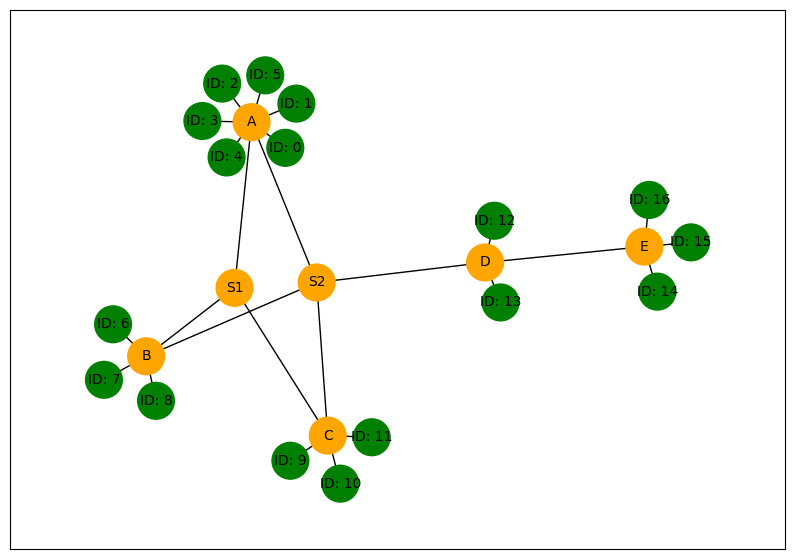

In [611]:
plt.figure(figsize =(10, 7))

pos = nx.kamada_kawai_layout(G,)
nx.draw_networkx_nodes(G, pos, node_size=700, margins=0.1, node_color=color_nodes)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

In [612]:
MUL_COUNT = len(mul_list)
OPERATIONS_FOR_MUL = [
    'move_to',
    'cheel'
]
MAX_MUL_OPERATIONS = 10
LENGTH_CHROM = MUL_COUNT * MAX_MUL_OPERATIONS     # длина хромосомы, подлежащей оптимизации
TRAIN_LIVE_TIME = {
    'S1': 5,
    'S2': 6
}

VAGON_OPERATIONS = {
    'idle': 2,
    'move': 4
}

# константы генетического алгоритма
POPULATION_SIZE = 300   # количество индивидуумов в популяции
P_CROSSOVER = 0.9       # вероятность скрещивания
P_MUTATION = 0.2        # вероятность мутации индивидуума
MAX_GENERATIONS = 60    # максимальное количество поколений
HALL_OF_FAME_SIZE = 4

In [613]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

In [614]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [615]:
def create_individ(max_range, count):
    res = {
        'commands': []
    }
    for _ in range(MAX_MUL_OPERATIONS):
        new_oper = random.randint(0, 10)
        if new_oper >= 1:
            station = random.choice(stations)
            res['commands'].append({'0': {"to": station, "who": random.randint(0, len(vagon_list)-1)}})
        else:
            res['commands'].append({'1': None})
    return res

In [616]:
create_individ(len(OPERATIONS_FOR_MUL) - 1, MAX_MUL_OPERATIONS)

{'commands': [{'0': {'to': 'A', 'who': 0}},
  {'0': {'to': 'B', 'who': 7}},
  {'0': {'to': 'S1', 'who': 3}},
  {'0': {'to': 'S1', 'who': 2}},
  {'0': {'to': 'D', 'who': 1}},
  {'1': None},
  {'0': {'to': 'B', 'who': 7}},
  {'0': {'to': 'E', 'who': 0}},
  {'0': {'to': 'B', 'who': 13}},
  {'0': {'to': 'D', 'who': 8}}]}

In [617]:
toolbox = base.Toolbox()
toolbox.register("randomOper", create_individ, len(OPERATIONS_FOR_MUL) - 1, MAX_MUL_OPERATIONS)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.randomOper, MUL_COUNT)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [618]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
population

[[{'commands': [{'1': None},
    {'0': {'to': 'S1', 'who': 13}},
    {'0': {'to': 'C', 'who': 4}},
    {'0': {'to': 'S2', 'who': 10}},
    {'0': {'to': 'A', 'who': 12}},
    {'0': {'to': 'C', 'who': 11}},
    {'0': {'to': 'C', 'who': 1}},
    {'0': {'to': 'E', 'who': 3}},
    {'0': {'to': 'A', 'who': 9}},
    {'0': {'to': 'E', 'who': 11}}]},
  {'commands': [{'0': {'to': 'B', 'who': 2}},
    {'1': None},
    {'0': {'to': 'B', 'who': 9}},
    {'0': {'to': 'S2', 'who': 7}},
    {'0': {'to': 'D', 'who': 8}},
    {'0': {'to': 'S1', 'who': 11}},
    {'0': {'to': 'C', 'who': 11}},
    {'0': {'to': 'S1', 'who': 8}},
    {'0': {'to': 'S1', 'who': 2}},
    {'0': {'to': 'S1', 'who': 5}}]},
  {'commands': [{'0': {'to': 'S1', 'who': 7}},
    {'0': {'to': 'D', 'who': 12}},
    {'0': {'to': 'S1', 'who': 7}},
    {'0': {'to': 'C', 'who': 1}},
    {'0': {'to': 'S2', 'who': 1}},
    {'0': {'to': 'D', 'who': 8}},
    {'0': {'to': 'B', 'who': 10}},
    {'0': {'to': 'S1', 'who': 15}},
    {'0': {'to': 'S1'

In [619]:
def is_conflict(command_list: list) -> bool:
    "Проверка: тащат ли несколько мулов один вагон?"
    vagon_move = []
    for command in command_list:  # command = {'1': None} / {'0': {'to': 'B', 'who': 3}}
        key, val = list(command.items())[0]
        if key == '0':
            if val['who'] in vagon_move: return True
            vagon_move.append(val['who'])
    return False 

def new_vagon_state(new_vagon_list, command_list, time):
    "обновление расписания вагонов. Только обновление на основании расчетов мулов"
    new_state_for_vagon = {}  # список изменений, которые произшли за единицу времени


    # составляем что-то вроде общего расписания за единицу времени
    for command in command_list:
        key, val = list(command.items())[0]
        if key == '0':
            vagon = new_vagon_list[val['who']]
            # vagon['st'] = val['to']
            if val['to'] in ['S1', 'S2']:  # если мы попали в поезд
                vagon['was_in_train'] = time  # устанавливаем временную отметку
            new_state_for_vagon[f'{val["who"]}'] = val['to']
    
    for key, val in new_state_for_vagon.items():
        new_vagon_list[int(key)]['history'][time] = val  # если вагон двигали, то записываем это в историю вагонов

    return new_vagon_list

In [620]:
def is_graph_move_valid(from_st: str, to: str) -> bool:
    ind_from = stations.index(from_st)
    ind_to = stations.index(to)

    return False if graph_matrix[ind_from][ind_to] == 0 else True

In [621]:
PENALTY_COST = 20

def shedule_cost(individual):
    "Эту функцию я всю проверил в ручную, работает правильно"
    current_cost = 0
    penalty_count = 0

    new_vagon_list = copy.deepcopy(vagon_list)  # это глубокое копирование, чтобы скопировались все элементы вснутри списка

    # синхронизируем действия мулов

    for time in range(MAX_MUL_OPERATIONS):
        command_list = [individual[mul]['commands'][time] for mul in range(MUL_COUNT)]
        if is_conflict(command_list):
            penalty_count += 1
        
        new_vagon_state(new_vagon_list, command_list, time)  # состовляем расписание

    # проведем стоимость расписания

    for i, vagon in enumerate(new_vagon_list):
        train = None
        for time in range(len(vagon['history'])):
            command = vagon['history'][time]
            if train is not None and time >= TRAIN_LIVE_TIME[train] and vagon['was_in_train'] <= TRAIN_LIVE_TIME[train]:  # если мы в поезде и поезд уже уехал
                if command is not None:  # если после отъезда поезда мы решили перекинуть вагон, то...
                    penalty_count += 1  # бан
            else:
                if command is None:
                    current_cost += VAGON_OPERATIONS['idle']
                else:
                    if command in ['S1', 'S2']:
                        current_cost -= 2
                        train = command
                        penalty_count += 1 if time > TRAIN_LIVE_TIME[train] else 0  # если мы попали в поезд после его отправления, то бан
                    else:
                        train = None
                    
                    if is_graph_move_valid(vagon['st'], command) is False:
                        penalty_count += 1
                    
                    vagon['st'] = command
                    
                    current_cost += VAGON_OPERATIONS['move']
    
    current_cost += penalty_count * PENALTY_COST  # прибавляем штраф к общей сумме
    return current_cost,

In [622]:
population[0]

[{'commands': [{'1': None},
   {'0': {'to': 'S1', 'who': 13}},
   {'0': {'to': 'C', 'who': 4}},
   {'0': {'to': 'S2', 'who': 10}},
   {'0': {'to': 'A', 'who': 12}},
   {'0': {'to': 'C', 'who': 11}},
   {'0': {'to': 'C', 'who': 1}},
   {'0': {'to': 'E', 'who': 3}},
   {'0': {'to': 'A', 'who': 9}},
   {'0': {'to': 'E', 'who': 11}}]},
 {'commands': [{'0': {'to': 'B', 'who': 2}},
   {'1': None},
   {'0': {'to': 'B', 'who': 9}},
   {'0': {'to': 'S2', 'who': 7}},
   {'0': {'to': 'D', 'who': 8}},
   {'0': {'to': 'S1', 'who': 11}},
   {'0': {'to': 'C', 'who': 11}},
   {'0': {'to': 'S1', 'who': 8}},
   {'0': {'to': 'S1', 'who': 2}},
   {'0': {'to': 'S1', 'who': 5}}]},
 {'commands': [{'0': {'to': 'S1', 'who': 7}},
   {'0': {'to': 'D', 'who': 12}},
   {'0': {'to': 'S1', 'who': 7}},
   {'0': {'to': 'C', 'who': 1}},
   {'0': {'to': 'S2', 'who': 1}},
   {'0': {'to': 'D', 'who': 8}},
   {'0': {'to': 'B', 'who': 10}},
   {'0': {'to': 'S1', 'who': 15}},
   {'0': {'to': 'S1', 'who': 14}},
   {'0': {'to'

In [623]:
shedule_cost(population[0])

(860,)

In [624]:
def mate(ind1, ind2):
    for i in range(len(ind1)):
        ind1[i]['commands'], ind2[i]['commands'] = tools.cxTwoPoint(ind1[i]['commands'], ind2[i]['commands'])
    return ind1, ind2

In [625]:
def mut(individual, indpb):
    for i in range(len(individual)):                
        individual[i]['commands'] = list(tools.mutShuffleIndexes(individual[i]['commands'], indpb))[0]
    return individual,

In [626]:
toolbox.register("evaluate", shedule_cost)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", mate)
toolbox.register("mutate", mut, indpb=1.0/MAX_MUL_OPERATIONS)

In [627]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

In [628]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

In [629]:
population, logbook = elitism.eaSimpleWithElitism(population, toolbox,
                                        cxpb=P_CROSSOVER,
                                        mutpb=P_MUTATION,
                                        ngen=MAX_GENERATIONS,
                                        halloffame=hof,
                                        stats=stats,
                                        verbose=True)

gen	nevals	min	avg    
0  	300   	638	811.573
1  	277   	632	767.273
2  	278   	586	736.927
3  	275   	522	704.3  
4  	264   	522	674.06 
5  	278   	512	642.96 
6  	266   	478	606.333
7  	278   	406	584.407
8  	275   	406	552.633
9  	274   	388	524.153
10 	274   	342	501.087
11 	278   	342	481.987
12 	267   	300	460.707
13 	265   	294	438.033
14 	274   	294	419.247
15 	267   	292	397.62 
16 	270   	286	376.267
17 	271   	276	361.127
18 	269   	260	341.987
19 	270   	248	326.073
20 	274   	240	315.353
21 	272   	240	304.2  
22 	276   	240	295.793
23 	284   	236	291.773
24 	268   	232	284.5  
25 	270   	232	279.84 
26 	267   	228	277.947
27 	271   	212	273.953
28 	257   	212	271.813
29 	273   	210	268.38 
30 	286   	210	266    
31 	275   	210	261.587
32 	272   	210	258.207
33 	277   	210	253.607
34 	274   	210	251.693
35 	269   	210	246.5  
36 	283   	210	244.767
37 	276   	210	239.087
38 	270   	210	232.74 
39 	268   	210	228.88 
40 	270   	210	224.407
41 	272   	208	224.66 
42 	277   	

In [630]:
maxFitnessValues, meanFitnessValues = logbook.select("min", "avg")

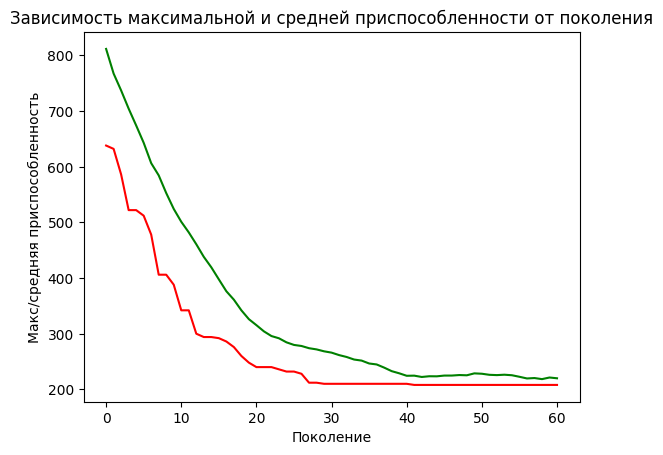

In [631]:
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Поколение')
plt.ylabel('Макс/средняя приспособленность')
plt.title('Зависимость максимальной и средней приспособленности от поколения')
 
plt.show()

In [632]:
best_shedule = hof.items[0]
best_shedule

[{'commands': [{'0': {'to': 'S2', 'who': 8}},
   {'0': {'to': 'S1', 'who': 4}},
   {'0': {'to': 'S2', 'who': 9}},
   {'0': {'to': 'S2', 'who': 1}},
   {'0': {'to': 'S1', 'who': 7}},
   {'0': {'to': 'S2', 'who': 13}},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None}]},
 {'commands': [{'0': {'to': 'S1', 'who': 10}},
   {'0': {'to': 'D', 'who': 16}},
   {'0': {'to': 'S1', 'who': 5}},
   {'0': {'to': 'S2', 'who': 12}},
   {'0': {'to': 'S2', 'who': 16}},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None}]},
 {'commands': [{'1': None},
   {'0': {'to': 'S1', 'who': 3}},
   {'0': {'to': 'S2', 'who': 0}},
   {'0': {'to': 'S1', 'who': 2}},
   {'0': {'to': 'S1', 'who': 6}},
   {'0': {'to': 'S2', 'who': 11}},
   {'1': None},
   {'1': None},
   {'1': None},
   {'1': None}]}]

In [633]:
PENALTY_COST = 20

def new_shedule(best_shedule):
    "Эту функцию я всю проверил в ручную, работает правильно"
    current_cost = 0
    penalty_count = 0

    new_vagon_list = copy.deepcopy(vagon_list)  # это глубокое копирование, чтобы скопировались все элементы вснутри списка

    # синхронизируем действия мулов

    for time in range(MAX_MUL_OPERATIONS):
        command_list = [best_shedule[mul]['commands'][time] for mul in range(MUL_COUNT)]
        if is_conflict(command_list):
            penalty_count += 1
        
        new_vagon_state(new_vagon_list, command_list, time)  # состовляем расписание

    # проведем стоимость расписания

    for i, vagon in enumerate(new_vagon_list):
        train = None
        for time in range(len(vagon['history'])):
            command = vagon['history'][time]
            if train is not None and time >= TRAIN_LIVE_TIME[train] and vagon['was_in_train'] <= TRAIN_LIVE_TIME[train]:  # если мы в поезде и поезд уже уехал
                if command is not None:  # если после отъезда поезда мы решили перекинуть вагон, то...
                    penalty_count += 1  # бан
            else:
                if command is None:
                    current_cost += VAGON_OPERATIONS['idle']
                else:
                    if command in ['S1', 'S2']:
                        train = command
                        penalty_count += 1 if time > TRAIN_LIVE_TIME[train] else 0  # если мы попали в поезд после его отправления, то бан
                    else:
                        train = None
                    
                    if is_graph_move_valid(vagon['st'], command) is False:
                        penalty_count += 1
                    
                    vagon['st'] = command
                    
                    current_cost += VAGON_OPERATIONS['move']
    
    current_cost += penalty_count * PENALTY_COST  # прибавляем штраф к общей сумме
    
    return new_vagon_list, current_cost, penalty_count

In [634]:
new_vagon_list, current_cost, penalty_count = new_shedule(best_shedule)
print(current_cost)
print(penalty_count)
new_vagon_list

238
0


[{'st': 'S2',
  'was_in_train': 2,
  'history': [None, None, 'S2', None, None, None, None, None, None, None]},
 {'st': 'S2',
  'was_in_train': 3,
  'history': [None, None, None, 'S2', None, None, None, None, None, None]},
 {'st': 'S1',
  'was_in_train': 3,
  'history': [None, None, None, 'S1', None, None, None, None, None, None]},
 {'st': 'S1',
  'was_in_train': 1,
  'history': [None, 'S1', None, None, None, None, None, None, None, None]},
 {'st': 'S1',
  'was_in_train': 1,
  'history': [None, 'S1', None, None, None, None, None, None, None, None]},
 {'st': 'S1',
  'was_in_train': 2,
  'history': [None, None, 'S1', None, None, None, None, None, None, None]},
 {'st': 'S1',
  'was_in_train': 4,
  'history': [None, None, None, None, 'S1', None, None, None, None, None]},
 {'st': 'S1',
  'was_in_train': 4,
  'history': [None, None, None, None, 'S1', None, None, None, None, None]},
 {'st': 'S2',
  'was_in_train': 0,
  'history': ['S2', None, None, None, None, None, None, None, None, None]},
 

In [635]:
G = nx.Graph()
color_map = []
color_nodes = ['orange' for _ in range(len(stations))] + ['green' for _ in range(len(new_vagon_list))]

for key, value in transitions.items():
    for val in value:
        G.add_edge(key, val, color='b', weight=3)
        color_map.append('orange')

for i in range(len(new_vagon_list)):
    G.add_edge(new_vagon_list[i]['st'], f"ID: {i}", color='g', weight=1, capacity=15)
    color_map.append('blue')

{'S1': Text(-0.5558014075785094, 0.14493352571003804, 'S1'),
 'A': Text(-0.2540001861252342, -0.18522903923269116, 'A'),
 'B': Text(-0.10958332381718139, 0.16779230095167028, 'B'),
 'C': Text(-0.17953981246688785, 0.006677778005020214, 'C'),
 'S2': Text(0.18380837177601755, -0.17782064423825342, 'S2'),
 'D': Text(0.5484628157050678, 0.034694402990425616, 'D'),
 'E': Text(0.9059209020081348, 0.13138084208430792, 'E'),
 'ID: 0': Text(0.2770101025675304, -0.0944166373995011, 'ID: 0'),
 'ID: 1': Text(0.10848590075652371, -0.28657162245356566, 'ID: 1'),
 'ID: 2': Text(-0.507640353440858, 0.04410589269658577, 'ID: 2'),
 'ID: 3': Text(-0.4524380621610998, 0.18760036183762388, 'ID: 3'),
 'ID: 4': Text(-0.603363955930957, 0.26721815629052026, 'ID: 4'),
 'ID: 5': Text(-0.6729917656064792, 0.19018505986465523, 'ID: 5'),
 'ID: 6': Text(-0.6729984231361974, 0.08620341616313668, 'ID: 6'),
 'ID: 7': Text(-0.6056002044336254, 0.019075355820766412, 'ID: 7'),
 'ID: 8': Text(0.202195448765952, -0.0464599

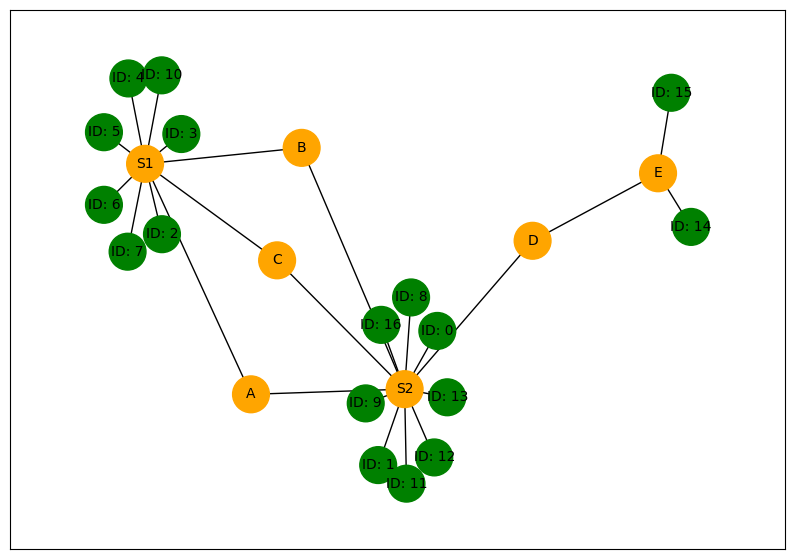

In [636]:
plt.figure(figsize =(10, 7))

pos = nx.kamada_kawai_layout(G,)
nx.draw_networkx_nodes(G, pos, node_size=700, margins=0.1, node_color=color_nodes)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

In [637]:
new_vagon_list[16]

{'st': 'S2',
 'was_in_train': 4,
 'history': [None, 'D', None, None, 'S2', None, None, None, None, None]}